In [1]:
%pylab inline
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.grid_search import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#инициализация DataFrame'а
pd.set_option('display.max_columns', 70);
sample = pd.read_csv("DM_problem.csv", ";");
test1 = pd.read_csv("Diabet_test1.csv", ";");
test2 = pd.read_csv("Diabet_test2.csv", ";");
sample.head()
#test1.head()
#test2.head()

,ID,Mean д0,Stdev д0,CONGA д0,LI д0,JINDEX д,LBGI д0,HBGI д0,MVALUE д0,MAG д0,N,Гипо д0,Mean н1,Stdev н1,CONGA н1,LI н1,J-index н1,LBGI н1,HBGI н1,M-value н1,MAG н1,N.1,Гипо ночь 1,Инсулин НПХ,Доза НПХ У,Доза НПХ В,Гларгин (Лантус),Доза гларгина,Левемир (Детемир),Доза детемира У,Доза детемира В,ИКД,Доза ИКД,ИУКД,Доза ИУКД,...,Доза микста У,Доза микста В,Суточная доза инсулина,Режим инсулинотер.,1-НПХ 2-Лант 0-Др,Лантуса на кг,НПХ на кг,НПХ В на кг,Базального на кг,Возраст,Пол,"ИМТ, кг/м2",Длительность инсулинотерапии,Длительность СД,"HbA1C, %",Гипогликемии в анамнезе,Нарушенное распознавание гипогликемий,Метформин,Доза,Mean е0,Stdev е0,JINDEX е0,LBGI е0,HBGI е0,MVALUE е0,MAG е0,daltaG e0,Mean е1,Stdev е1,JINDEX е1,LBGI е1,HBGI е1,MVALUE е1,MAG е1,deltaG e1
0,2 день 1,12,2,11,3,69,0,17,22,2,192,0,12,1,11,0,57,0,15,18,1,96,0,0,0,0,1,14,0,0,0,1,42,0,0,...,0,0,56,3,2,0.145833,0,0,0.145833,77,1,31.0,7,11,10.5,1,0,0,0,13.91,0.28,65.27,0.00,22.53,32.65,1.09,-1.0,16.60,0.39,93.54,0.00,33.66,62.22,1.76,-0.7
1,1 день 1,6,1,5,2,15,3,1,3,2,192,1,4,1,4,0,8,6,0,10,1,96,1,0,0,0,0,0,0,0,0,1,6,0,0,...,28,23,57,2,0,0.000000,0,0,0.000000,75,2,40.0,9,12,NaN,1,0,1,1700,3.63,0.24,4.84,10.41,0.00,19.28,0.85,-0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4 день 1,6,2,5,3,20,2,2,2,3,192,1,4,1,4,0,9,7,0,11,2,96,1,0,0,0,0,0,1,21,21,1,22,1,28,...,0,0,92,3,0,0.000000,0,0,0.000000,65,1,32.7,4,10,7.52,1,0,0,0,5.68,1.00,14.45,1.92,0.37,1.61,3.09,-2.8,5.37,0.48,11.10,1.09,0.00,1.26,2.06,-1.6
3,5 день 1,7,1,7,1,25,0,3,1,2,192,0,9,0,8,0,28,0,4,2,1,96,0,0,0,0,0,0,1,21,21,1,22,1,28,...,0,0,92,3,0,0.000000,0,0,0.000000,67,2,31.6,5,25,9.21,1,0,1,1700,9.93,0.43,34.81,0.00,7.53,5.32,1.39,-1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6 день 1,7,1,7,1,23,3,2,1,3,192,0,6,1,4,2,15,2,1,2,3,96,1,0,0,0,0,0,0,0,0,0,0,1,15,...,16,12,43,2,0,0.000000,0,0,0.000000,75,2,36.0,7,36,6.94,1,0,0,0,8.44,0.24,24.40,0.00,3.15,1.11,1.58,-0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#выявление неинформативных признаков
for name in sample.columns:
    s = sample[name].value_counts()
    if s.empty == False:
        if list(s)[0] > int(0.8 * sample.index.size):
            print 'poor informativity: ', name
    if sample[name].dtype != 'object':
        if sample[name].var() == 0:
            print 'feature is constant: ', name
    

poor informativity:  N
feature is constant:  N
poor informativity:  N.1
poor informativity:  Доза детемира У
poor informativity:  Доза детемира В
poor informativity:  Нарушенное распознавание гипогликемий


In [4]:
#удаление неинформативных признаков
sample = sample.drop(["ID", "N", "N.1", "Доза детемира У", "Доза детемира В", "Нарушенное распознавание гипогликемий", "HbA1C, %"], axis = 1);
test1 = test1.drop(["ID", "Доза детемира У", "Доза детемира В", "Нарушенное распознавание гипогликемий", "HbA1C, %"], axis = 1);
test2 = test2.drop(["ID", "Доза детемира У", "Доза детемира В", "Нарушенное распознавание гипогликемий", "HbA1C, %"], axis = 1);
#удаление объекта, о котором мало информации
sample = sample.drop(sample.index[35]) 
sample.head()

,Mean д0,Stdev д0,CONGA д0,LI д0,JINDEX д,LBGI д0,HBGI д0,MVALUE д0,MAG д0,Гипо д0,Mean н1,Stdev н1,CONGA н1,LI н1,J-index н1,LBGI н1,HBGI н1,M-value н1,MAG н1,Гипо ночь 1,Инсулин НПХ,Доза НПХ У,Доза НПХ В,Гларгин (Лантус),Доза гларгина,Левемир (Детемир),ИКД,Доза ИКД,ИУКД,Доза ИУКД,Фиксированная смесь инсулинов,Доза микста У,Доза микста В,Суточная доза инсулина,Режим инсулинотер.,1-НПХ 2-Лант 0-Др,Лантуса на кг,НПХ на кг,НПХ В на кг,Базального на кг,Возраст,Пол,"ИМТ, кг/м2",Длительность инсулинотерапии,Длительность СД,Гипогликемии в анамнезе,Метформин,Доза,Mean е0,Stdev е0,JINDEX е0,LBGI е0,HBGI е0,MVALUE е0,MAG е0,daltaG e0,Mean е1,Stdev е1,JINDEX е1,LBGI е1,HBGI е1,MVALUE е1,MAG е1,deltaG e1
0,12,2,11,3,69,0,17,22,2,0,12,1,11,0,57,0,15,18,1,0,0,0,0,1,14,0,1,42,0,0,0,0,0,56,3,2,0.145833,0,0,0.145833,77,1,31.0,7,11,1,0,0,13.91,0.28,65.27,0.00,22.53,32.65,1.09,-1.0,16.60,0.39,93.54,0.00,33.66,62.22,1.76,-0.7
1,6,1,5,2,15,3,1,3,2,1,4,1,4,0,8,6,0,10,1,1,0,0,0,0,0,0,1,6,0,0,1,28,23,57,2,0,0.000000,0,0,0.000000,75,2,40.0,9,12,1,1,1700,3.63,0.24,4.84,10.41,0.00,19.28,0.85,-0.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6,2,5,3,20,2,2,2,3,1,4,1,4,0,9,7,0,11,2,1,0,0,0,0,0,1,1,22,1,28,0,0,0,92,3,0,0.000000,0,0,0.000000,65,1,32.7,4,10,1,0,0,5.68,1.00,14.45,1.92,0.37,1.61,3.09,-2.8,5.37,0.48,11.10,1.09,0.00,1.26,2.06,-1.6
3,7,1,7,1,25,0,3,1,2,0,9,0,8,0,28,0,4,2,1,0,0,0,0,0,0,1,1,22,1,28,0,0,0,92,3,0,0.000000,0,0,0.000000,67,2,31.6,5,25,1,1,1700,9.93,0.43,34.81,0.00,7.53,5.32,1.39,-1.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,1,7,1,23,3,2,1,3,0,6,1,4,2,15,2,1,2,3,1,0,0,0,0,0,0,0,0,1,15,1,16,12,43,2,0,0.000000,0,0,0.000000,75,2,36.0,7,36,1,0,0,8.44,0.24,24.40,0.00,3.15,1.11,1.58,-0.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
sample.describe()

,Mean д0,Stdev д0,CONGA д0,LI д0,JINDEX д,LBGI д0,HBGI д0,MVALUE д0,MAG д0,Гипо д0,Mean н1,Stdev н1,CONGA н1,LI н1,J-index н1,LBGI н1,HBGI н1,M-value н1,MAG н1,Гипо ночь 1,Инсулин НПХ,Доза НПХ У,Доза НПХ В,Гларгин (Лантус),Доза гларгина,Левемир (Детемир),ИКД,Доза ИКД,ИУКД,Доза ИУКД,Фиксированная смесь инсулинов,Доза микста У,Доза микста В,Суточная доза инсулина,Режим инсулинотер.,1-НПХ 2-Лант 0-Др,Лантуса на кг,НПХ на кг,НПХ В на кг,Базального на кг,Возраст,Пол,"ИМТ, кг/м2",Длительность инсулинотерапии,Длительность СД,Гипогликемии в анамнезе,Метформин,Доза,Mean е0,Stdev е0,JINDEX е0,LBGI е0,HBGI е0,MVALUE е0,MAG е0,daltaG e0,Mean е1,Stdev е1,JINDEX е1,LBGI е1,HBGI е1,MVALUE е1,MAG е1,deltaG e1
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,35.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000
mean,8.394737,2.157895,7.105263,4.657895,38.289474,2.947368,6.973684,9.368421,3.210526,0.447368,6.657895,1.000000,6.105263,0.763158,22.289474,2.236842,3.078947,6.894737,1.526316,0.342105,0.263158,5.289474,4.131579,0.263158,6.657895,0.210526,0.342105,7.342105,0.605263,10.921053,0.263158,6.000000,5.868421,54.526316,2.421053,0.789474,0.096145,0.124021,0.056092,0.220166,71.314286,1.857143,32.932746,8.028571,18.971429,0.485714,0.371429,632.857143,7.514737,0.375000,22.167632,1.813158,3.432895,6.592368,1.787632,-0.455263,7.831667,0.265556,24.050556,1.088333,4.388889,7.011111,1.370556,-0.383333
std,2.086501,0.945153,1.983574,3.181673,18.857801,4.937158,5.395127,11.114687,0.990711,0.503897,2.612613,0.615125,2.586759,0.970768,19.824784,3.612547,6.148529,12.244777,0.687213,0.480783,0.446258,9.655996,7.953143,0.446258,12.281113,0.413155,0.480783,12.972479,1.174952,15.724626,0.446258,11.763434,11.230198,27.714507,0.758076,0.843349,0.158989,0.236278,0.110597,0.237813,4.020327,0.355036,4.898145,4.508069,8.034798,0.507093,0.490241,866.275229,2.491563,0.188203,13.586351,5.061592,4.953392,12.857245,0.839258,0.935688,3.024417,0.158234,20.138204,3.054238,8.105860,15.132615,0.796769,0.689629
min,6.000000,1.000000,4.000000,1.000000,15.000000,0.000000,1.000000,1.000000,2.000000,0.000000,3.000000,0.000000,3.000000,0.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.000000,1.000000,25.600000,1.000000,6.000000,0.000000,0.000000,0.000000,2.830000,0.080000,2.940000,0.000000,0.000000,0.010000,0.420000,-2.800000,3.430000,0.060000,4.640000,0.000000,0.000000,0.000000,0.300000,-1.600000
25%,7.000000,2.000000,6.000000,2.250000,26.250000,0.000000,3.000000,2.000000,2.250000,0.000000,5.000000,1.000000,5.000000,0.000000,11.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.250000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.500000,2.000000,28.450000,5.000000,12.000000,0.000000,0.000000,0.000000,5.765000,0.250000,12.832500,0.000000,0.040000,0.402500,1.150000,-1.150000,5.795000,0.135000,12.520000,0.000000,0.002500,0.262500,0.730000,-0.700000
50%,8.000000,2.000000,7.000000,3.000000,32.000000,1.500000,5.000000,5.500000,3.000000,0.000000,6.000000,1.000000,5.000000,0.500000,16.000000,1.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

In [6]:
#найдем пустые значения
for name in sample.columns:
    if sample[sample[name].isnull()].size != 0:
        print "____________", name
        print sample[name].value_counts()

____________ Лантуса на кг
0.000000    24
0.278481     1
0.528736     1
0.367347     1
0.423529     1
0.265060     1
0.145833     1
0.200000     1
0.185567     1
0.463768     1
0.285714     1
0.221053     1
Name: Лантуса на кг, dtype: int64
____________ НПХ на кг
0.000000    26
0.485294     1
0.476190     1
0.837838     1
0.233010     1
0.731343     1
0.272727     1
0.268293     1
0.521739     1
0.514286     1
Name: НПХ на кг, dtype: int64
____________ НПХ В на кг
0.000000    26
0.116505     1
0.190476     1
0.161765     1
0.121951     1
0.090909     1
0.405405     1
0.260870     1
0.358209     1
0.257143     1
Name: НПХ В на кг, dtype: int64
____________ Базального на кг
0.000000    15
0.285714     1
0.514286     1
0.221053     1
0.521739     1
0.268293     1
0.272727     1
0.463768     1
0.185567     1
0.731343     1
0.485294     1
0.476190     1
0.145833     1
0.265060     1
0.423529     1
0.233010     1
0.837838     1
0.367347     1
0.528736     1
0.278481     1
0.200000     1
Name

In [7]:
#найдем пустые значения в тестовых выборках
for name in test1.columns:
    if test1[test1[name].isnull()].size != 0:
        print "TEST1____________", name
        print test1[name].value_counts()
for name in test2.columns:
    if test1[test2[name].isnull()].size != 0:
        print "TEST2____________", name
        print test2[name].value_counts()
#как результат - пробелов в тестовых выборках нет

In [8]:
#заполненение пробелов
#почти все значения нулевые
sample["Лантуса на кг"][sample["Лантуса на кг"].isnull()] = 0.0 
sample["Лантуса на кг"][sample["НПХ на кг"].isnull()] = 0.0
sample["НПХ на кг"][sample["НПХ на кг"].isnull()] = 0.0
sample["НПХ В на кг"][sample["НПХ В на кг"].isnull()] = 0.0
sample["Базального на кг"][sample["Базального на кг"].isnull()] = 0.0
sample["Доза"][sample["Доза"].isnull()] = 0.0
sample["LBGI е1"][sample["LBGI е1"].isnull()] = 0.0

#разброс значений, неизвестным будет приписано среднее
sample["Mean е1"][sample["Mean е1"].isnull()] = sample.mean()["Mean е1"]
sample["Возраст"][sample["Возраст"].isnull()] = int(round(sample.mean()["Возраст"]))
sample["ИМТ, кг/м2"][sample["ИМТ, кг/м2"].isnull()] = sample.mean()["ИМТ, кг/м2"]
sample["Длительность инсулинотерапии"][sample["Длительность инсулинотерапии"].isnull()] = int(round(sample.mean()["Длительность инсулинотерапии"]))
sample["Длительность СД"][sample["Длительность СД"].isnull()] = int(round(sample.mean()["Длительность СД"]))
sample["Stdev е1"][sample["Stdev е1"].isnull()] = sample.mean()["Stdev е1"]
sample["JINDEX е1"][sample["JINDEX е1"].isnull()] = sample.mean()["JINDEX е1"]
sample["HBGI е1"][sample["HBGI е1"].isnull()] = sample.mean()["HBGI е1"]
sample["MVALUE е1"][sample["MVALUE е1"].isnull()] = sample.mean()["MVALUE е1"]
sample["MAG е1"][sample["MAG е1"].isnull()] = sample.mean()["MAG е1"]
sample["deltaG e1"][sample["deltaG e1"].isnull()] = sample.mean()["deltaG e1"]

#большинство значений равно 2
sample["Пол"][sample["Пол"].isnull()] = 2

#значений 0 и 1 примерно поровну, пусть будет среднее
sample["Гипогликемии в анамнезе"][sample["Гипогликемии в анамнезе"].isnull()] = sample.mean()["Гипогликемии в анамнезе"]
sample["Метформин"][sample["Метформин"].isnull()] = sample.mean()["Метформин"]

In [9]:
#нормализация данных
mins = {}
deltas = {}
for name in sample.columns:
    if name != "Гипо ночь 1":
        mins[name] = sample[name].min()
        deltas[name] = (sample[name].max() - sample[name].min())
        sample[name] = (sample[name] - mins[name]) / deltas[name]
        #sample[name] = (sample[name] - sample[name].mean()) / sample[name].std()
for name in test2.columns:
        test1[name] = (test1[name] - mins[name]) / deltas[name]
        test2[name] = (test2[name] - mins[name]) / deltas[name]
sample.head()

,Mean д0,Stdev д0,CONGA д0,LI д0,JINDEX д,LBGI д0,HBGI д0,MVALUE д0,MAG д0,Гипо д0,Mean н1,Stdev н1,CONGA н1,LI н1,J-index н1,LBGI н1,HBGI н1,M-value н1,MAG н1,Гипо ночь 1,Инсулин НПХ,Доза НПХ У,Доза НПХ В,Гларгин (Лантус),Доза гларгина,Левемир (Детемир),ИКД,Доза ИКД,ИУКД,Доза ИУКД,Фиксированная смесь инсулинов,Доза микста У,Доза микста В,Суточная доза инсулина,Режим инсулинотер.,1-НПХ 2-Лант 0-Др,Лантуса на кг,НПХ на кг,НПХ В на кг,Базального на кг,Возраст,Пол,"ИМТ, кг/м2",Длительность инсулинотерапии,Длительность СД,Гипогликемии в анамнезе,Метформин,Доза,Mean е0,Stdev е0,JINDEX е0,LBGI е0,HBGI е0,MVALUE е0,MAG е0,daltaG e0,Mean е1,Stdev е1,JINDEX е1,LBGI е1,HBGI е1,MVALUE е1,MAG е1,deltaG e1
0,0.666667,0.25,0.777778,0.181818,0.551020,0.000000,0.64,0.446809,0.00,0,0.750000,0.333333,0.666667,0.000000,0.553191,0.00,0.555556,0.352941,0.0,0,0,0,0,1,0.304348,0,1,0.913043,0.000000,0.000000,0,0.000000,0.000000,0.264706,1.0,1,0.275815,0,0,0.174059,1.000000,0,0.323353,0.30,0.166667,1,0,0.00,1.000000,0.217391,1.000000,0.000000,1.000000,0.621005,0.230241,0.391304,1.000000,0.750000,1.000000,0.000000,1.000000,1.000000,0.572549,0.391304
1,0.000000,0.00,0.111111,0.090909,0.000000,0.130435,0.00,0.042553,0.00,1,0.083333,0.333333,0.083333,0.000000,0.031915,0.30,0.000000,0.196078,0.0,1,0,0,0,0,0.000000,0,1,0.130435,0.000000,0.000000,1,0.682927,0.560976,0.272059,0.5,0,0.000000,0,0,0.000000,0.833333,1,0.862275,0.40,0.200000,1,1,0.85,0.072202,0.173913,0.030483,0.481054,0.000000,0.366629,0.147766,0.456522,0.334219,0.467172,0.218341,0.000000,0.130389,0.112683,0.419826,0.528986
2,0.000000,0.25,0.111111,0.181818,0.051020,0.086957,0.04,0.021277,0.25,1,0.083333,0.333333,0.083333,0.000000,0.042553,0.35,0.000000,0.215686,0.5,1,0,0,0,0,0.000000,1,1,0.478261,0.142857,0.437500,0,0.000000,0.000000,0.529412,1.0,0,0.000000,0,0,0.000000,0.000000,0,0.425150,0.15,0.133333,1,0,0.00,0.257220,1.000000,0.184662,0.088725,0.016423,0.030441,0.917526,0.000000,0.147304,0.954545,0.072666,0.084496,0.000000,0.020251,0.690196,0.000000
3,0.111111,0.00,0.333333,0.000000,0.102041,0.000000,0.08,0.000000,0.00,0,0.500000,0.000000,0.416667,0.000000,0.244681,0.00,0.148148,0.039216,0.0,0,0,0,0,0,0.000000,1,1,0.478261,0.142857,0.437500,0,0.000000,0.000000,0.529412,1.0,0,0.000000,0,0,0.000000,0.166667,1,0.359281,0.20,0.633333,1,1,0.85,0.640794,0.380435,0.511311,0.000000,0.334221,0.101027,0.333333,0.347826,0.334219,0.467172,0.218341,0.000000,0.130389,0.112683,0.419826,0.528986
4,0.111111,0.00,0.333333,0.000000,0.081633,0.130435,0.04,0.000000,0.25,0,0.250000,0.333333,0.083333,0.666667,0.106383,0.10,0.037037,0.039216,1.0,1,0,0,0,0,0.000000,0,0,0.000000,0.142857,0.234375,1,0.390244,0.292683,0.169118,0.5,0,0.000000,0,0,0.000000,0.833333,1,0.622754,0.30,1.000000,1,0,0.00,0.506318,0.173913,0.344296,0.000000,0.139814,0.020928,0.398625,0.434783,0.334219,0.467172,0.218341,0.000000,0.130389,0.112683,0.419826,0.528986


In [10]:
#разделение обучающей выборки
hypo = sample[sample["Гипо ночь 1"] == 1]
no_hypo = sample[sample["Гипо ночь 1"] == 0]

In [ ]:
#Визуальное представление признака "Stdev д0" с разными значениями классифицируемого признака
name = "Stdev д0"
figure(figsize=(15, 2.5))
grid(True)
xlabel(name.decode("utf-8"))
yes = (hypo[hypo[name].isnull() == False])[name]
no = (no_hypo[no_hypo[name].isnull() == False])[name]
scatter(yes[:], zeros(len(yes)), c='red', s=50, alpha = 0.5)  
scatter(no[:], zeros(len(no)), c='blue', s=50, alpha = 0.5)

density = gaussian_kde(yes)
xs = linspace(min(yes)-0.01, max(yes)+0.01, 100)
plot(xs, density(xs), linewidth=2.5, color='red')
density = gaussian_kde(no)
xs = linspace(min(no)-0.01, max(no)+0.01, 100)
plot(xs, density(xs), linewidth=2.5, color='blue')

In [ ]:
#Аналогично для всех признаков; выделим визуально разделимые:
scalar = 0.02
i = 0
for name in (sample.drop("Гипо ночь 1", axis = 1)).columns:
    print i, ": ", name 
    figure(figsize=(15, 2.5))
    grid(True)
    label = str(i) + ": " + name.decode("utf-8")
    title(label)
    yes = (hypo[hypo[name].isnull() == False])[name]
    no = (no_hypo[no_hypo[name].isnull() == False])[name]
    scatter(yes[:], scalar * abs(randn(len(yes))), c='red', s=50, alpha = 0.5)  
    scatter(no[:], (- 1) * scalar * abs(randn(len(no))), c='blue', s=50, alpha = 0.5)
    density = gaussian_kde(yes)
    xs = linspace(min(yes)-0.01, max(yes)+0.01, 100)
    plot(xs, density(xs), linewidth=2.5, color='red')
    density = gaussian_kde(no)
    xs = linspace(min(no)-0.01, max(no)+0.01, 100)
    plot(xs, density(xs), linewidth=2.5, color='blue')
    i += 1

In [11]:
#наиболее "перспективные" признаки
features = ["Mean д0", "JINDEX д", "LBGI д0", "MAG д0", "Mean н1", "CONGA н1", "LBGI н1", "M-value н1",
            "Доза ИУКД", "ИМТ, кг/м2", "Mean е0", "JINDEX е0", "LBGI е0", "MVALUE е0", "MAG е0", "daltaG e0", 
            "Mean е1", "Stdev е1", "JINDEX е1", "HBGI е1", "MAG е1"]
scalar = 0.01

#признаки, встречающиеся в тестовых и обучающей выборке:
for str in (set(features) & set(test1.columns) & set(test2.columns)):
    print str.decode("utf-8")

MAG е0
Доза ИУКД
Mean е0
MAG д0
JINDEX е0
MVALUE е0
Mean д0
daltaG e0
LBGI д0
JINDEX д
ИМТ, кг/м2
LBGI е0


In [ ]:
#попробуем рассмотреть все возможные комбинации "перспективных" признаков:

#features = list(set(features) & set(test1.columns) & set(test2.columns))
for i in range(len(features)):
    for j in range(len(features) - 1, i, -1):
        label = "(%d, %d): (%s, %s)" % (i, j,features[i], features[j])
        print label
        figure(figsize=(5, 5))
        grid(True)
        title(label.decode("utf-8"))
        f1 = features[i]
        f2 = features[j]
        f1_yes = hypo[f1] + scalar * randn(len(hypo[f1]))
        f1_no = no_hypo[f1] + scalar * randn(len(no_hypo[f1]))
        f2_yes = hypo[f2] + scalar * randn(len(hypo[f2]))
        f2_no = no_hypo[f2] + scalar * randn(len(no_hypo[f2]))

        scatter(f1_yes.values[:], f2_yes.values[:], c='red', s=50, alpha = 0.5)  
        scatter(f1_no.values[:], f2_no.values[:], c='blue', s=50, alpha = 0.5)

In [12]:
#"перспективные" пары для всех признаков
pairs = ((0, 7), (0, 6), (0, 4), (1, 7), (1, 6), (2, 20), (2, 6), (3, 6), (4, 20), (4, 19), 
         (4, 17), (4, 17), (4, 10), (4, 8), (4, 7), (4, 6), (4, 5), (5, 7), (6, 20), (6, 19), 
         (6, 18), (6, 17), (6, 15), (6, 14), (6, 12), (6, 11), (6, 10), (6, 9), (6, 7), (7, 20),
         (7, 19), (7, 18), (8, 17), (10, 17), (10, 12), (10, 11), (11, 17), (12, 17), (14, 17), 
         (17, 19), (17, 18))
#для "перспективных" признаков, имеющихся в тестовых выборках
#pairs = ((0, 4), (0, 1), (1, 11), (1, 8), (1, 5), (1, 4), (1, 2), (2, 9), (2, 7), (2, 6), (2, 5), (2, 4), (3, 11), 
#         (3, 4), (4, 9), (4, 7), (4, 6), (5, 7), (5, 6), (7, 11), (7, 8), (8, 11), (9, 11))

In [ ]:
#графики "перспективных" пар:
for pair in pairs:
    i = pair[0]
    j = pair[1]
    label = "(%d, %d): (%s, %s)" % (i, j,features[i], features[j])
    print label
    figure(figsize=(5, 5))
    grid(True)
    title(label.decode("utf-8"))
    f1 = features[i]
    f2 = features[j]
    f1_yes = hypo[f1] + scalar * randn(len(hypo[f1]))
    f1_no = no_hypo[f1] + scalar * randn(len(no_hypo[f1]))
    f2_yes = hypo[f2] + scalar * randn(len(hypo[f2]))
    f2_no = no_hypo[f2] + scalar * randn(len(no_hypo[f2]))
    scatter(f1_yes.values[:], f2_yes.values[:], c='red', s=50, alpha = 0.5)  
    scatter(f1_no.values[:], f2_no.values[:], c='blue', s=50, alpha = 0.5)



In [13]:
y = sample["Гипо ночь 1"].replace(to_replace = {0 : "Red", 1: "Blue"})

In [14]:
def get_grid(data, border=1., step=.01):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step),
                         np.arange(y_min, y_max, step))

In [15]:
def plot_model(X, y, clf, name = ""):
    clf.fit(X, y)
    xx, yy = get_grid(X)
    predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    figure(figsize=(10, 7))
    grid(True)
    title(name.decode("utf-8"))
    pcolormesh(xx, yy, predicted, cmap='summer')
    scatter(X[:, 0], X[:, 1], c=y, s=100, cmap='summer', alpha=0.7)

In [16]:
def plot_accuracy(params, clf, X, y):
    grid_searcher = GridSearchCV(clf, params, cv=5)
    grid_searcher.fit(X, y)
    means = []
    stds = []
    for elem in grid_searcher.grid_scores_:
        means.append(np.mean(elem.cv_validation_scores))
        stds.append(sqrt(np.var(elem.cv_validation_scores)))
    means = np.array(means)
    stds = np.array(stds)

    figure(figsize=(8, 6))
    plot(range(1, 10), means)
    text(2, 0.95, "Max = %d %%" % (means.max() * 100))
    fill_between(range(len(means)), means + stds, means - stds, alpha = 0.1, facecolor='blue')
    xlabel('Number of nearest neighbours')
    ylabel('Accuracy')

In [ ]:
max_neigh = 10,
min_neigh = 1

In [ ]:
#Метод KNN (n = 1,2,..9) для всех "перспективных" пар 
for pair in pairs:
    f1 = features[pair[0]]
    f2 = features[pair[1]]
    name = "(%d, %d) = (%s, %s)" % (pair[0], pair[1], f1, f2)
    X = np.hstack([np.vstack(sample[f1]), np.vstack(sample[f2])])
    clf = KNN(n_neighbors=5)
    plot_model(X, y, clf, name)
    plot_accuracy({'n_neighbors': range(1, 20)}, clf, X, y)
    print "%s" % name

In [ ]:
#по результатам наименьшая ошибка (92 %) на признаках: 
#("LBGI н1", "Stdev е1") - 4 соседа, 
#("LBGI н1", "MAG е1") - 6 соседей, 
#("Mean н1", "Stdev е1") - 1 сосед

In [ ]:
#для тестовой выборки 1 признаки с наилучшими результатами не известны
test_features = list(set(features) & set(test1.columns))

#Метод KNN (n = 1,2,..9) для всех пар перспективных признаков, встречающихся в тестовой выборке
for i in range(len(test_features)):
    for j in range(len(test_features) - 1, i, -1):
        f1 = test_features[i]
        f2 = test_features[j]
        name = "(%d, %d) = (%s, %s)" % (i, j, f1, f2)
        X = np.hstack([np.vstack(sample[f1]), np.vstack(sample[f2])])
        clf = KNN(n_neighbors=5)
        plot_model(X, y, clf, name)
        plot_accuracy({'n_neighbors': range(1, 10)}, clf, X, y)
        print "%s" % name

In [22]:
# лучший результат 80% на признаках ("JINDEX е0", "MVALUE е0") с 1 ближайшим соседом
#(78%)
#("Доза ИУКД", "Mean е0") - 5 соседей
#(76%)
#("JINDEX е0", "daltaG e0") - 5 соседей,
#("JINDEX е0", "JINDEX д")- 3 соседа,
#("Mean е0", "daltaG e0") - 10 соседей (была отдельная проверка)
#("Доза ИУКД", "MVALUE е0") - 1 сосед
#("MAG е0", "JINDEX е0") - 5 соседей
best_pairs = (("JINDEX е0", "MVALUE е0", 1),
              ("Доза ИУКД", "Mean е0", 5), 
              ("MAG е0", "JINDEX е0", 5), ("Доза ИУКД", "MVALUE е0", 1), 
              ("Mean е0", "daltaG e0", 10), ("JINDEX е0", "JINDEX д", 3), ("JINDEX е0", "daltaG e0", 5))
for p in best_pairs:
    f1 = p[0]
    f2 = p[1]
    n_neigh = p[2]
    name = "(%s, %s)" % (f1, f2)
    X = np.hstack([np.vstack(sample[f1]), np.vstack(sample[f2])])
    clf = KNN(n_neighbors = n_neigh)
    clf.fit(X, y)
    X_test1 = np.hstack([np.vstack(test1[f1]), np.vstack(test1[f2])])
    y_test1 = test1["Гипо ночь 1"]
    predicted = clf.predict_proba(X_test1)
    err = abs(predicted.transpose()[0] - y_test1)
    error = 0
    for i in range(len(err)):
        error += err[i]

    print "(\"%s\", \"%s\"), N = %d, acc = %f" %(f1, f2, error, 1 - error/len(err))

("JINDEX е0", "MVALUE е0"), N = 8, acc = 0.578947
("Доза ИУКД", "Mean е0"), N = 6, acc = 0.684211
("MAG е0", "JINDEX е0"), N = 5, acc = 0.694737
("Доза ИУКД", "MVALUE е0"), N = 6, acc = 0.684211
("Mean е0", "daltaG e0"), N = 6, acc = 0.657895
("JINDEX е0", "JINDEX д"), N = 6, acc = 0.666667
("JINDEX е0", "daltaG e0"), N = 5, acc = 0.715789


In [23]:
def plot_3d(X, y, name = ""):
    fig = figure(figsize=(5, 5))
    ax = Axes3D(fig)
    grid(True)
    ax.set_title(name.decode("utf-8"))
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c = y, s=50, alpha = 0.5)  

(0, 11, 12): (JINDEX е0, daltaG e0, JINDEX д)
(0, 10, 12): (JINDEX е0, MAG е0, JINDEX д)
(0, 10, 11): (JINDEX е0, MAG е0, daltaG e0)
(0, 7, 12): (JINDEX е0, Mean е0, JINDEX д)
(0, 7, 11): (JINDEX е0, Mean е0, daltaG e0)
(0, 7, 10): (JINDEX е0, Mean е0, MAG е0)
(0, 6, 12): (JINDEX е0, Доза ИУКД, JINDEX д)
(0, 6, 11): (JINDEX е0, Доза ИУКД, daltaG e0)
(0, 6, 10): (JINDEX е0, Доза ИУКД, MAG е0)
(0, 6, 7): (JINDEX е0, Доза ИУКД, Mean е0)
(0, 4, 12): (JINDEX е0, MVALUE е0, JINDEX д)
(0, 4, 11): (JINDEX е0, MVALUE е0, daltaG e0)
(0, 4, 10): (JINDEX е0, MVALUE е0, MAG е0)
(0, 4, 7): (JINDEX е0, MVALUE е0, Mean е0)
(0, 4, 6): (JINDEX е0, MVALUE е0, Доза ИУКД)
(4, 11, 12): (MVALUE е0, daltaG e0, JINDEX д)
(4, 10, 12): (MVALUE е0, MAG е0, JINDEX д)
(4, 10, 11): (MVALUE е0, MAG е0, daltaG e0)
(4, 7, 12): (MVALUE е0, Mean е0, JINDEX д)
(4, 7, 11): (MVALUE е0, Mean е0, daltaG e0)
(4, 7, 10): (MVALUE е0, Mean е0, MAG е0)
(4, 6, 12): (MVALUE е0, Доза ИУКД, JINDEX д)
(4, 6, 11): (MVALUE е0, Доза ИУКД,

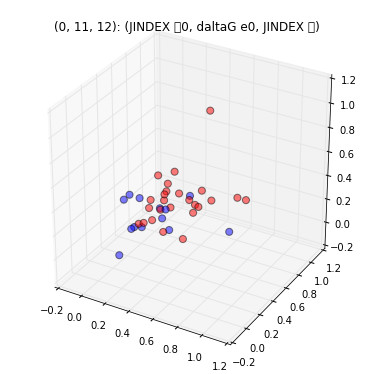

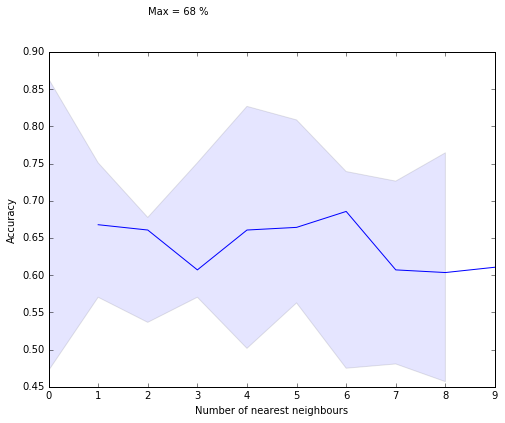

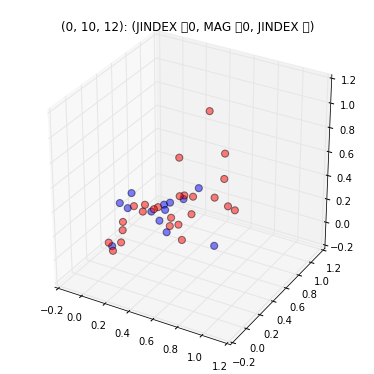

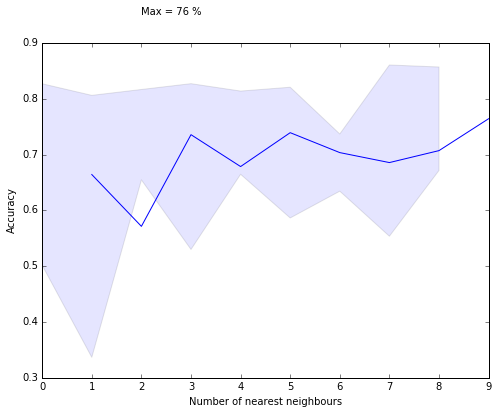

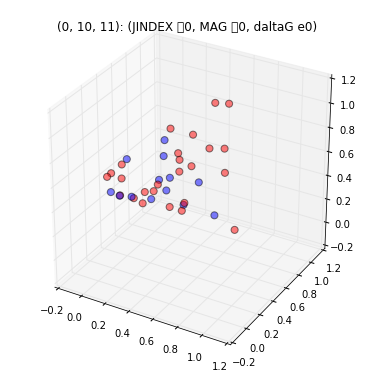

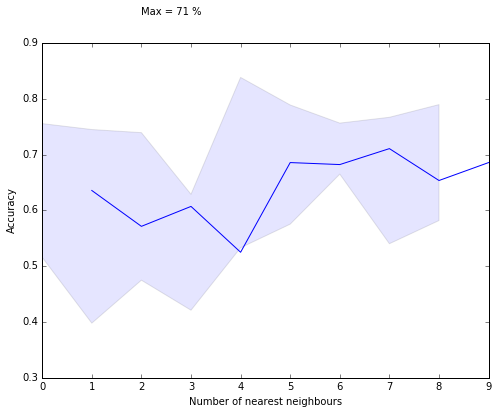

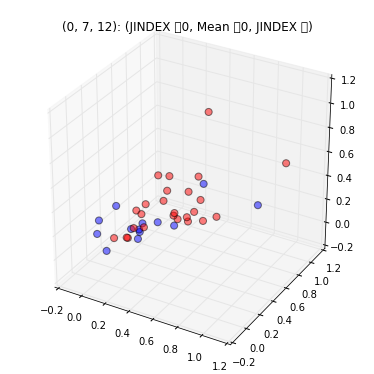

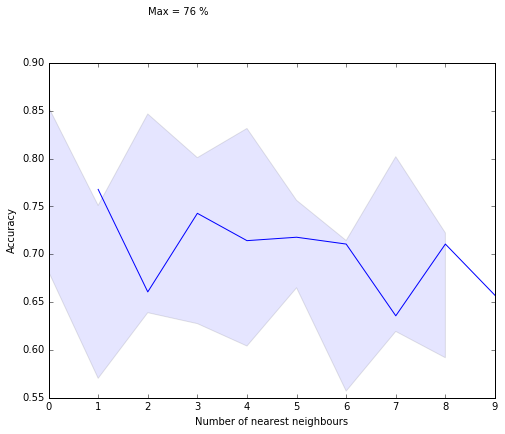

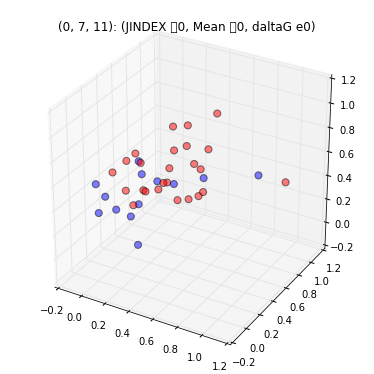

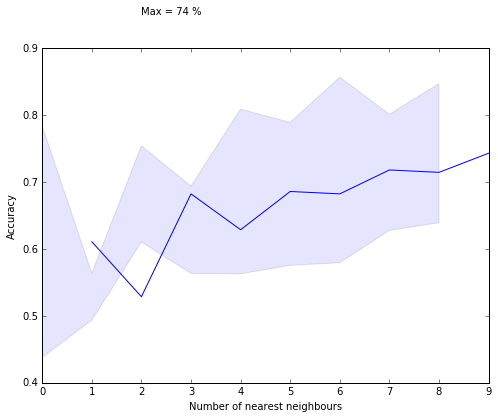

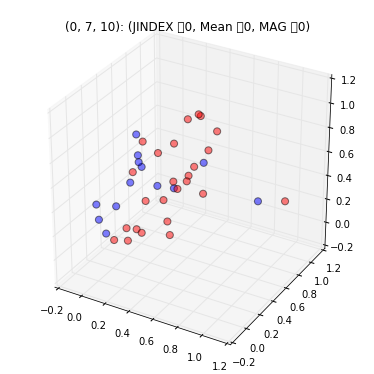

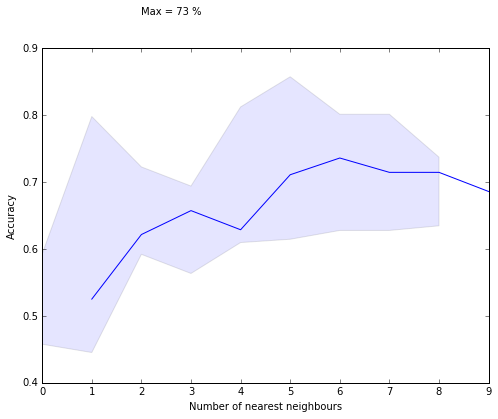

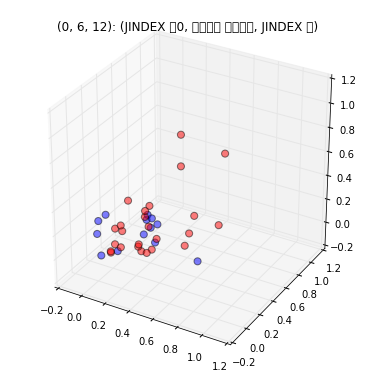

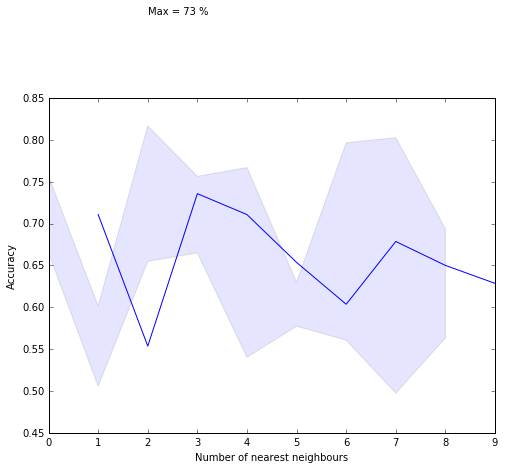

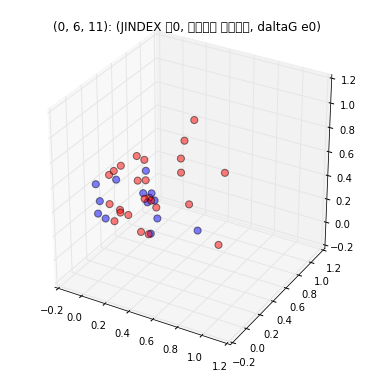

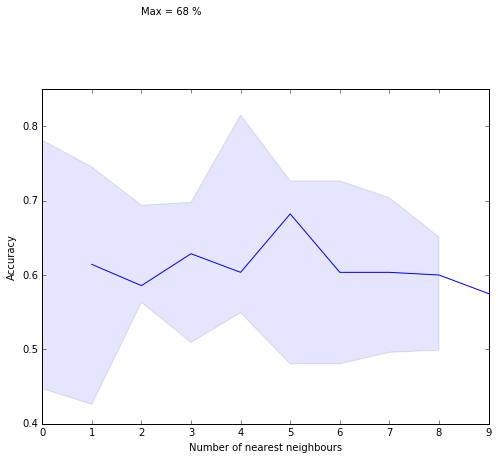

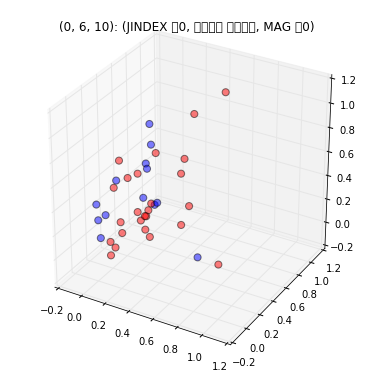

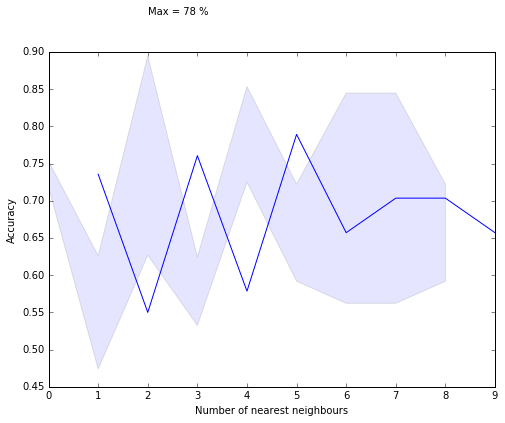

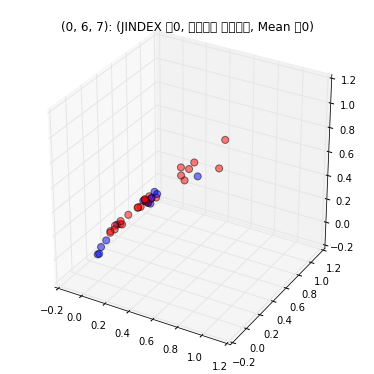

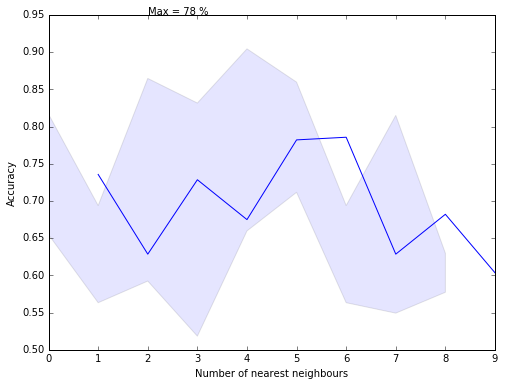

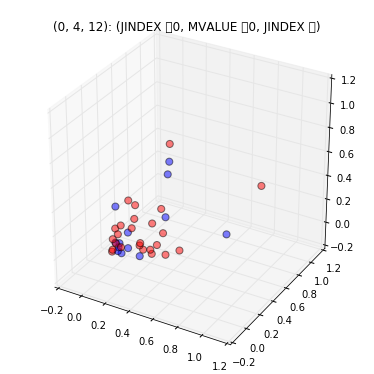

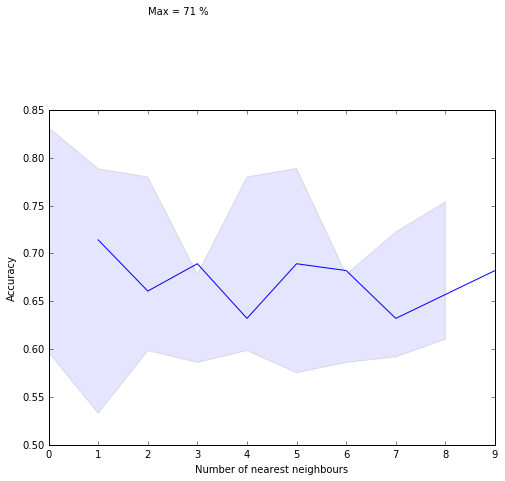

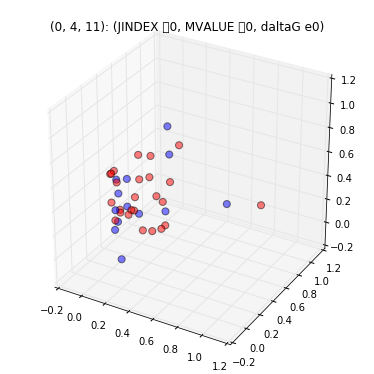

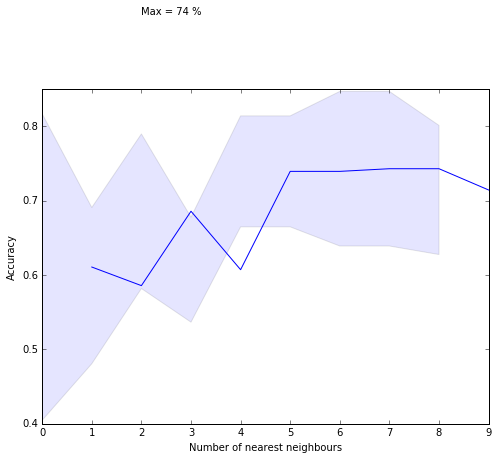

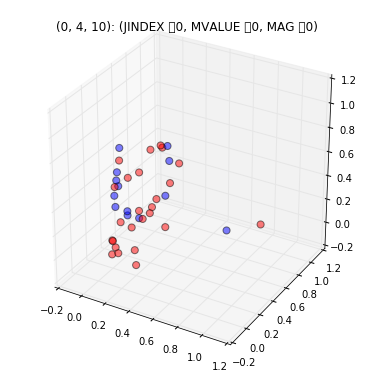

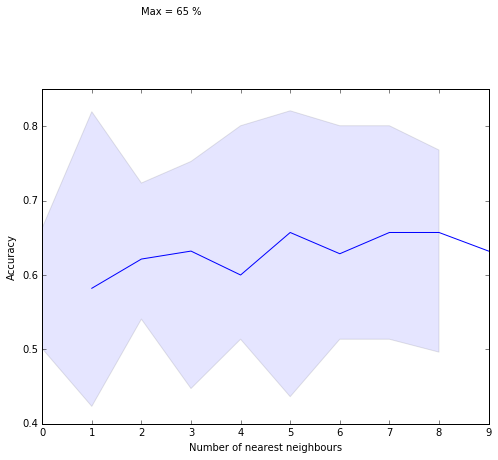

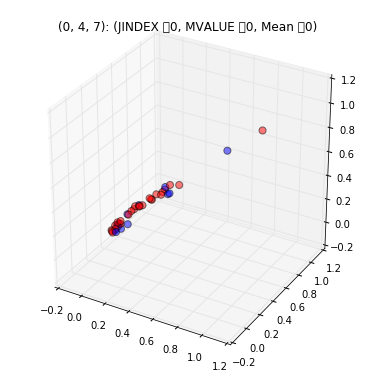

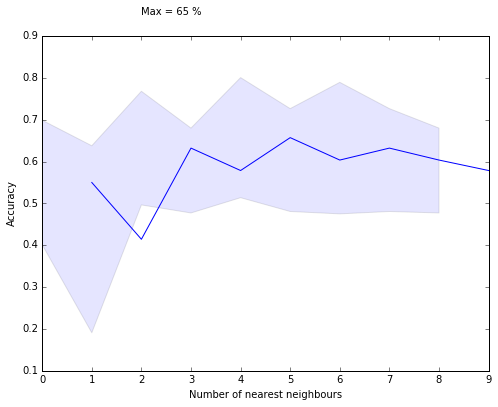

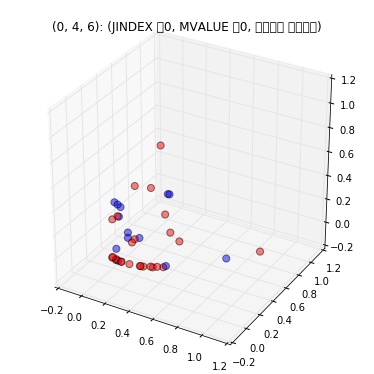

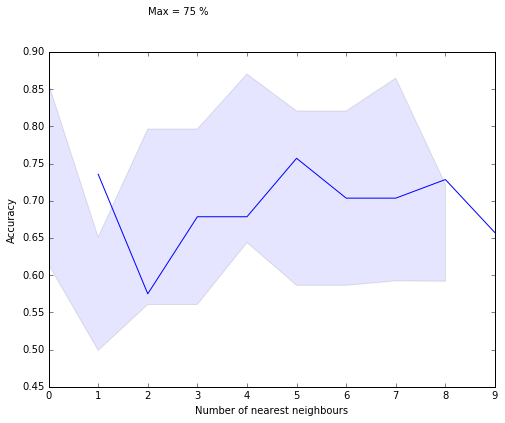

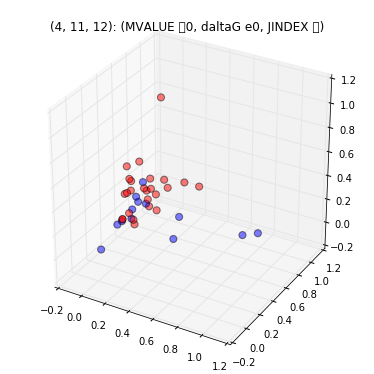

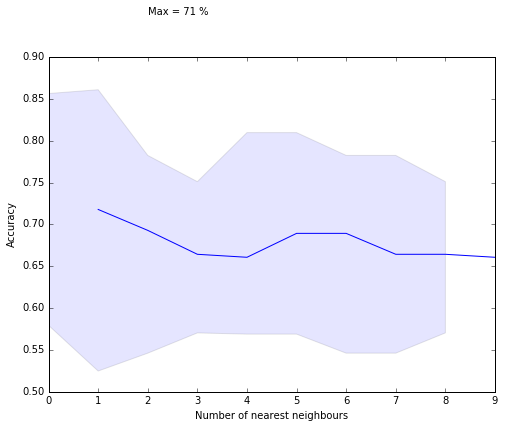

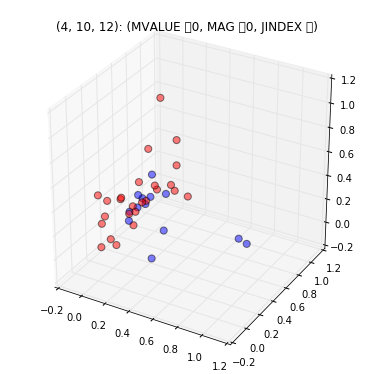

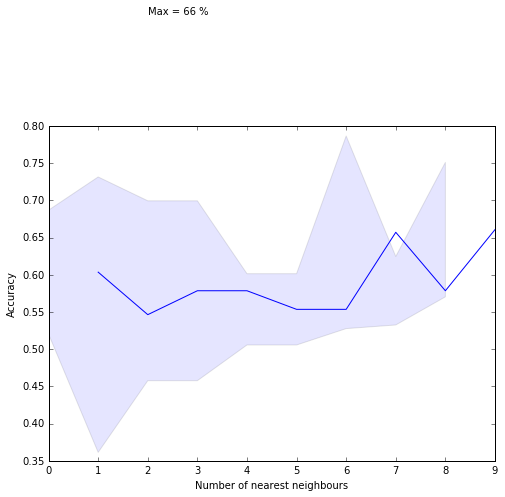

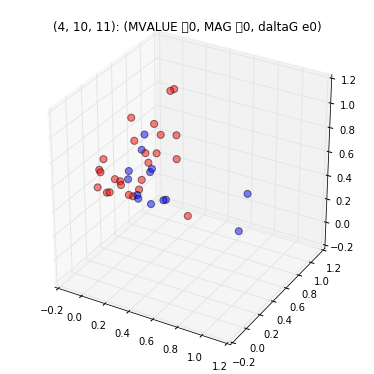

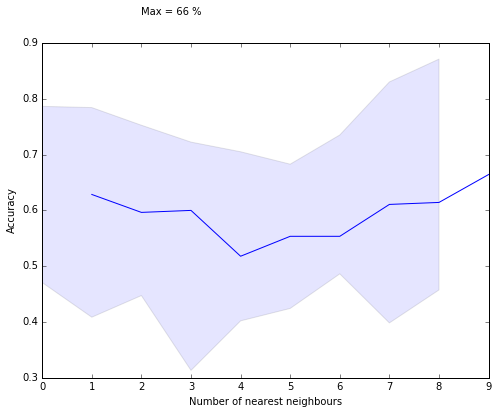

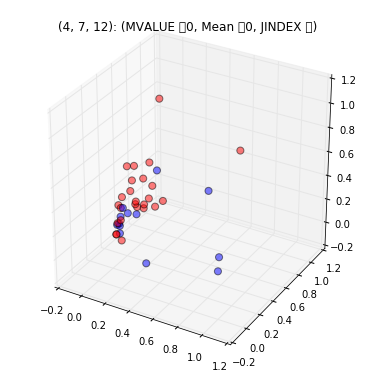

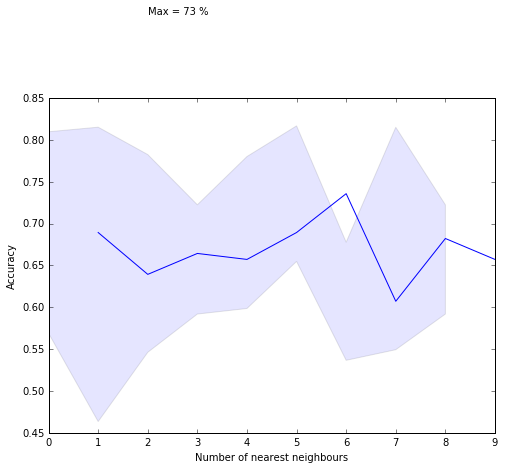

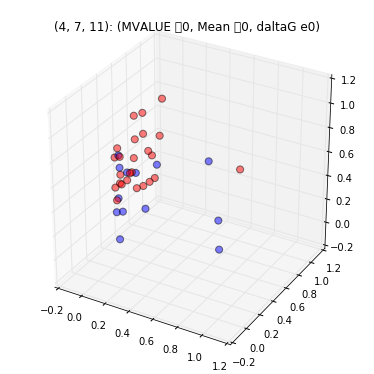

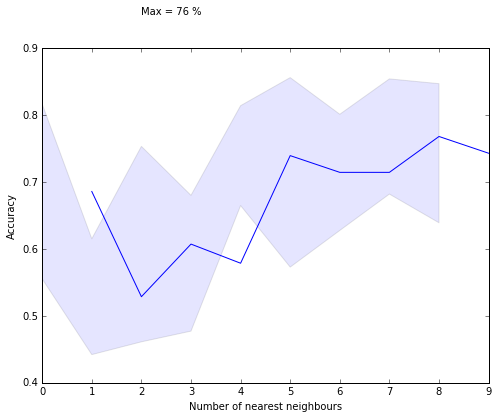

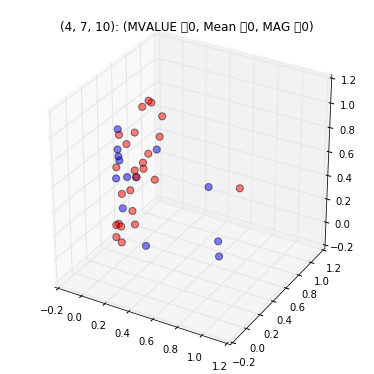

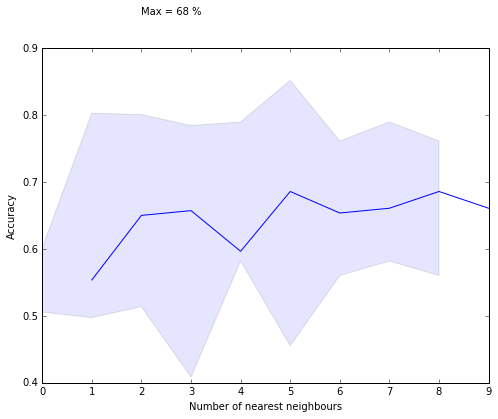

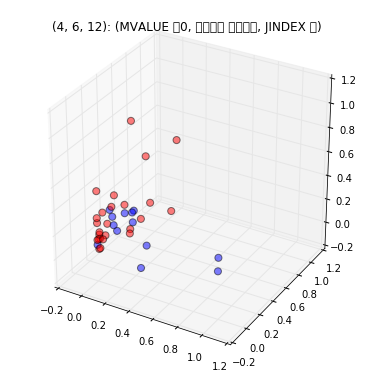

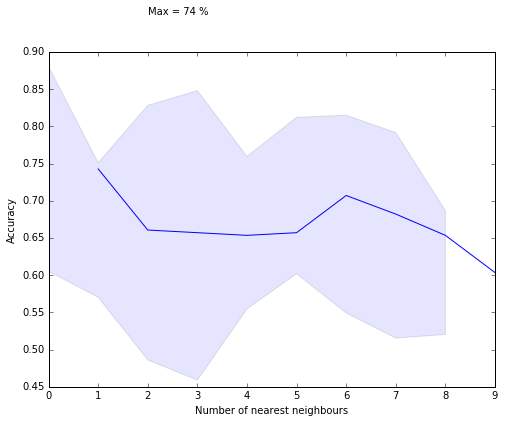

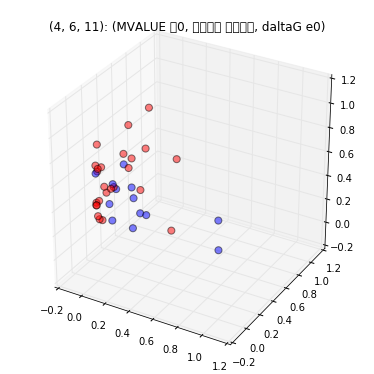

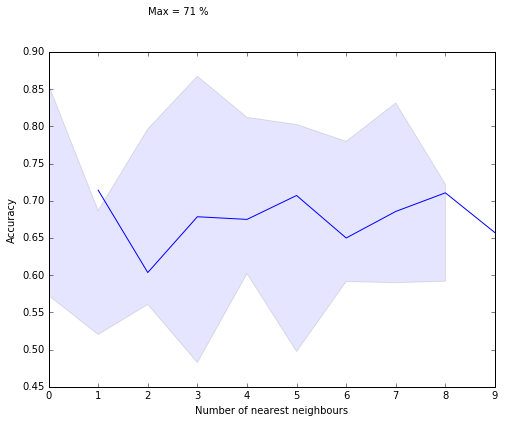

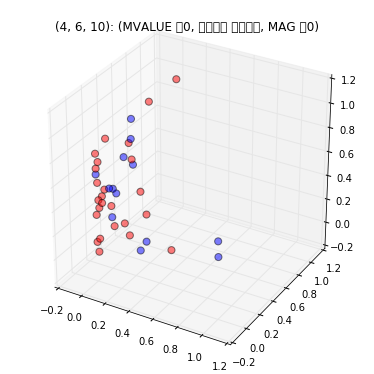

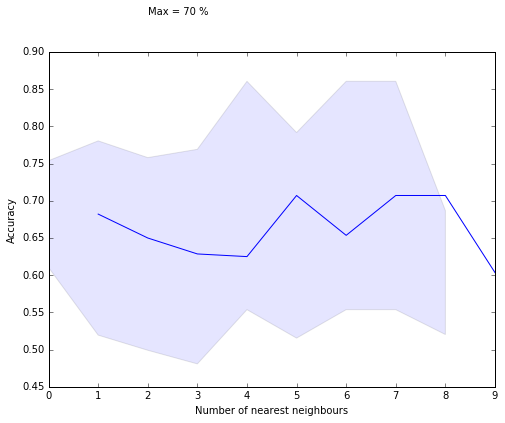

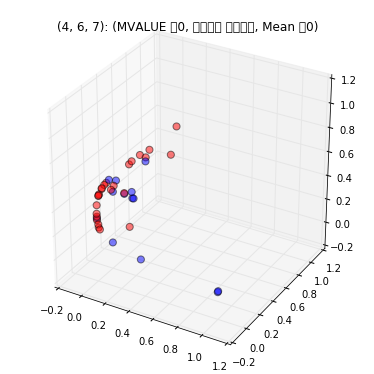

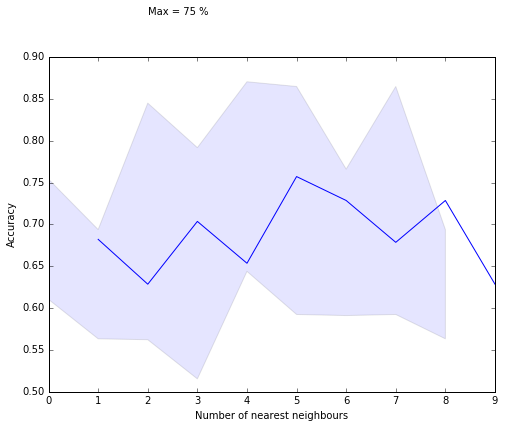

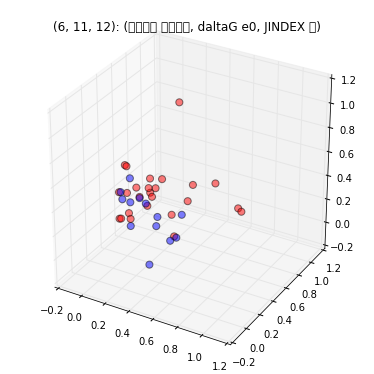

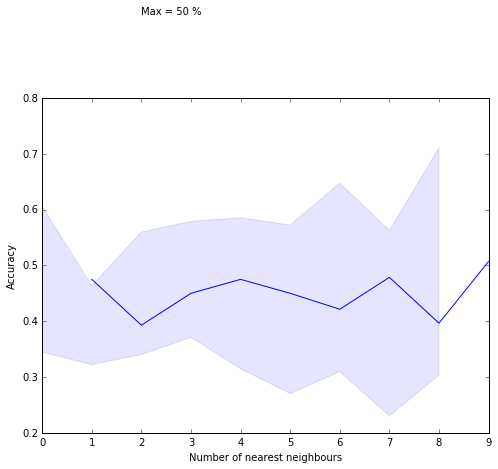

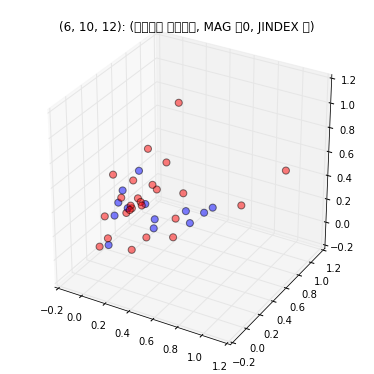

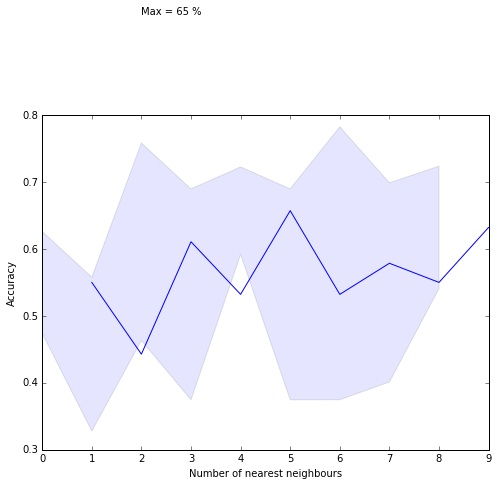

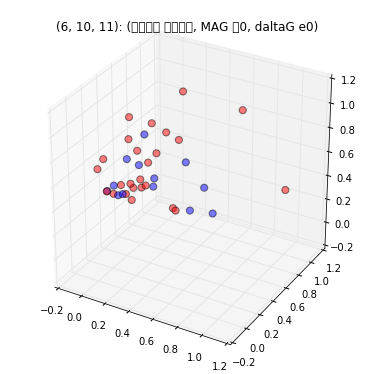

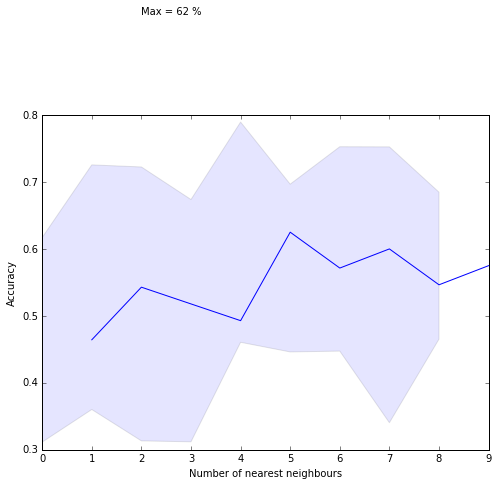

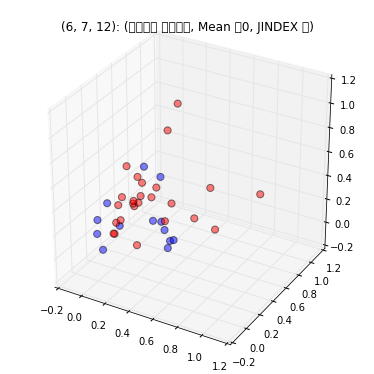

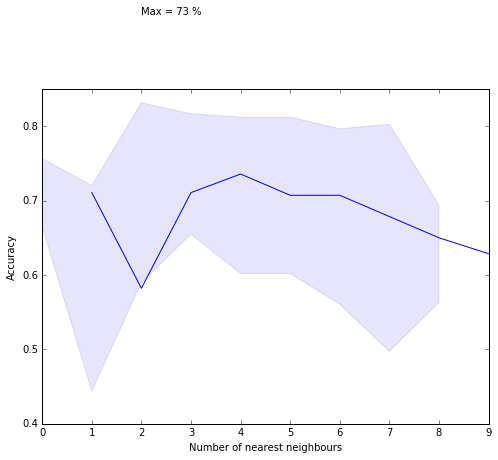

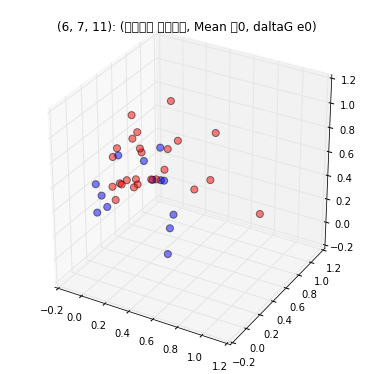

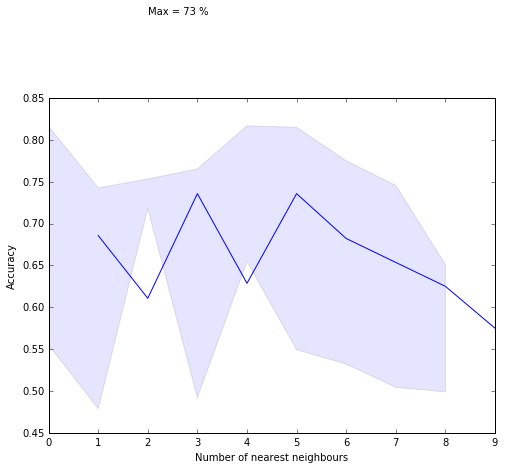

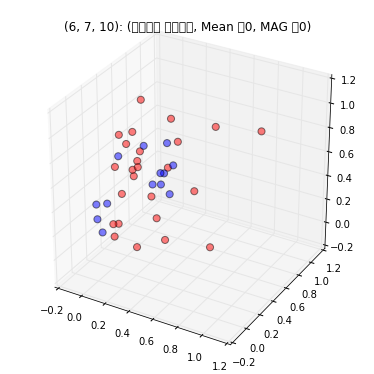

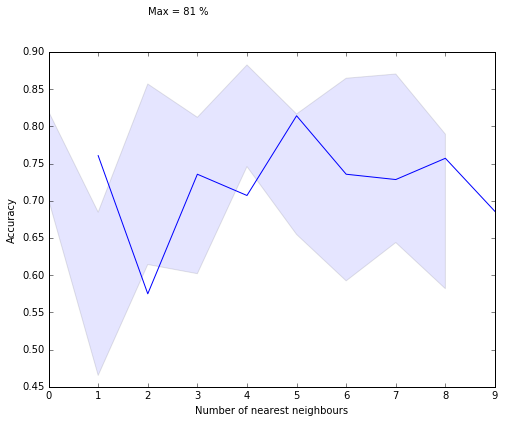

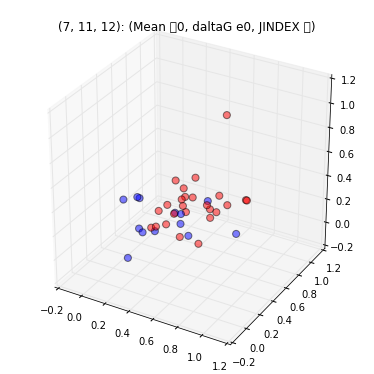

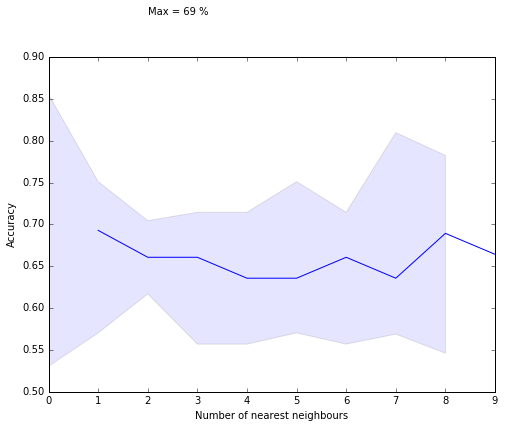

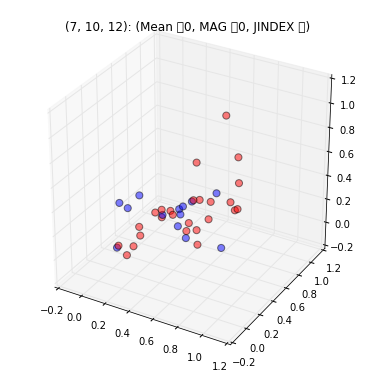

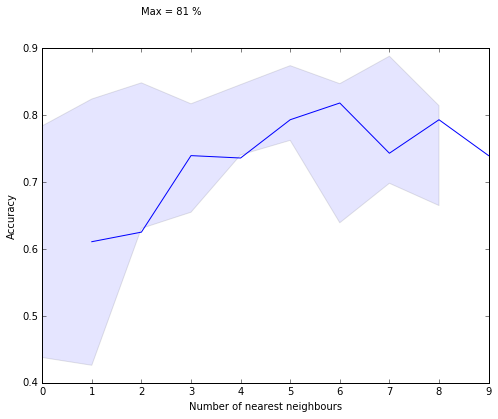

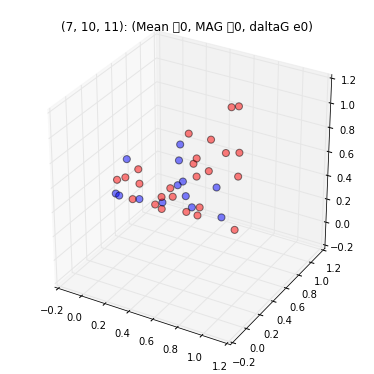

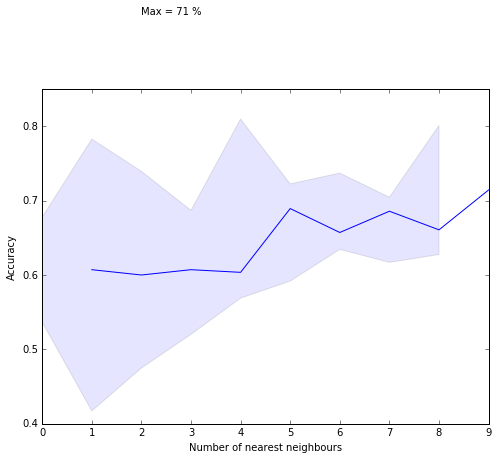

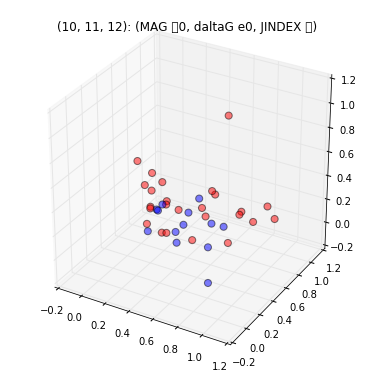

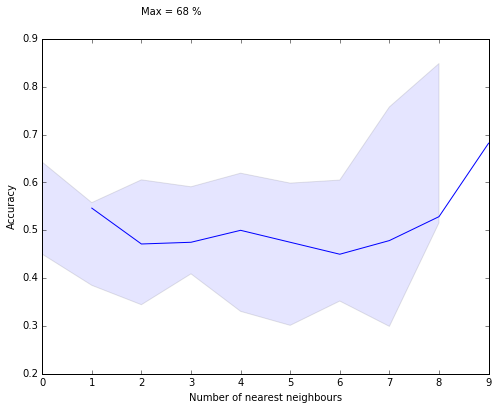

In [25]:
#наиболее часто встречающиеся индексы признаков в парах
bf_triplet = ("Mean д0", "Mean н1", "LBGI н1", "M-value н1", "Mean е0", "JINDEX е0", "LBGI е0", 
              "Stdev е1", "HBGI е1", "MAG е1")
#для признаков из тестовой выборки:
bf_triplet = ("JINDEX е0", "MVALUE е0", "Доза ИУКД", "Mean е0", "MAG е0", "daltaG e0", "JINDEX д")

#метод KNN для всех комбинаций из 3 признаков (рассматривались только признаки, чьи индексы есть в indexes)
for i in range(len(bf_triplet)):
    for j in range(len(bf_triplet) - 1, i, -1):
        for k in range(len(bf_triplet) - 1, j, -1):
            f1 = bf_triplet[i]
            f2 = bf_triplet[j]
            f3 = bf_triplet[k]
            name = "(%d, %d, %d): (%s, %s, %s)" % (indexes[i], indexes[j], indexes[k], f1, f2, f3)
            print name
            X = np.hstack([np.vstack(sample[f1]), np.vstack(sample[f2]), np.vstack(sample[f3])])
            plot_3d(X, y, name)
            
            clf = KNN(n_neighbors=5)
            clf.fit(X, y)
            plot_accuracy({'n_neighbors': range(1, 10)}, clf, X, y)
    
 

In [ ]:
#наилучший результат (95%): ("LBGI н1", "Stdev е1", "HBGI е1")
#Признаки, по которым классифицировались ответы с точностью от 90%:
#"Mean д0"
#"Mean н1"
#"LBGI н1"
#"M-value н1"
#"LBGI е0"
#"Stdev е1"
#"HBGI е1"
#"MAG е1"

#для признаков тестовой выборки максимальная по всем тройкам точность (81%)
#почти не увеличилась по сравнению с обучением на двух признаках(80%)

In [ ]:
best_features = ["Mean д0", "Mean н1", "LBGI н1", "M-value н1", "LBGI е0","Stdev е1","HBGI е1","MAG е1"]

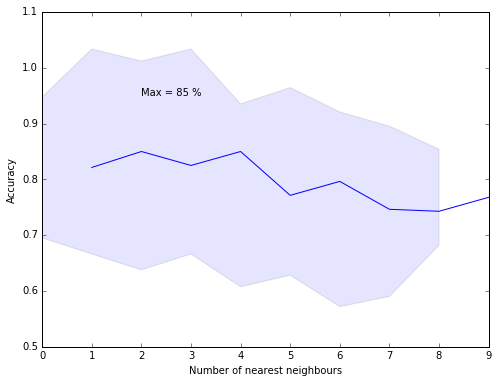

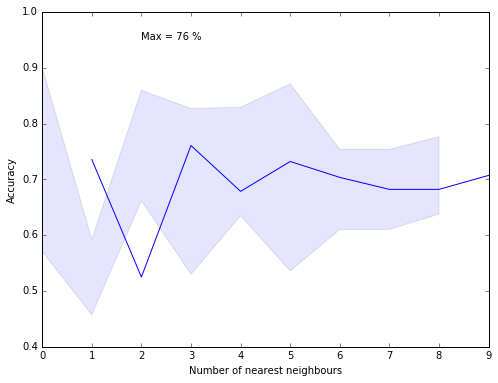

In [27]:
#KNN для набора признаков
X = np.hstack([np.vstack(sample["Mean д0"]), np.vstack(sample["Mean н1"]),
               np.vstack(sample["LBGI н1"]),
               np.vstack(sample["M-value н1"]), 
               np.vstack(sample["LBGI е0"]), 
               np.vstack(sample["Stdev е1"]),
               np.vstack(sample["HBGI е1"]),
               np.vstack(sample["MAG е1"])])
clf = KNN(n_neighbors=5)
clf.fit(X, y)
plot_accuracy({'n_neighbors': range(1, 10)}, clf, X, y)

X = np.hstack([np.vstack(sample["JINDEX е0"]), np.vstack(sample["MVALUE е0"]),
               np.vstack(sample["Доза ИУКД"]),
               np.vstack(sample["Mean е0"]), 
               np.vstack(sample["MAG е0"]), 
               np.vstack(sample["daltaG e0"]),
               np.vstack(sample["JINDEX д"])])
clf = KNN(n_neighbors=5)
clf.fit(X, y)
plot_accuracy({'n_neighbors': range(1, 10)}, clf, X, y)

In [71]:
#точность не улучшилась в сравнении с лучшим результатом для 2-3х признаков

best_pairs = (("JINDEX е0", "MVALUE е0", 1),
              ("Доза ИУКД", "Mean е0", 5), 
              ("MAG е0", "JINDEX е0", 5), ("Доза ИУКД", "MVALUE е0", 1), 
              ("Mean е0", "daltaG e0", 10), ("JINDEX е0", "JINDEX д", 3), ("JINDEX е0", "daltaG e0", 5))
for p in best_pairs:
    f1 = p[0]
    f2 = p[1]
    n_neigh = p[2]
    name = "(%s, %s)" % (f1, f2)
    X = np.hstack([np.vstack(sample[f1]), np.vstack(sample[f2])])
    clf = KNN(n_neighbors = n_neigh)
    clf.fit(X, y)
    X_test2 = np.hstack([np.vstack(test2[f1]), np.vstack(test2[f2])])
    predicted = clf.predict_proba(X_test2)
    predicted = predicted.transpose()[0]
    error = 0
    for i in range(len(predicted)):
        error += 0.5 - abs(predicted[i] - 0.5)

    print "(\"%s\", \"%s\"), uncertainly = %d" %(f1, f2, error)

 

("JINDEX е0", "MVALUE е0"), uncertainly = 0
("Доза ИУКД", "Mean е0"), uncertainly = 10
("MAG е0", "JINDEX е0"), uncertainly = 9
("Доза ИУКД", "MVALUE е0"), uncertainly = 0
("Mean е0", "daltaG e0"), uncertainly = 11
("JINDEX е0", "JINDEX д"), uncertainly = 7
("JINDEX е0", "daltaG e0"), uncertainly = 11


In [69]:
X1 = np.hstack([np.vstack(sample["JINDEX е0"]), np.vstack(sample["MVALUE е0"])])
X2 = np.hstack([np.vstack(sample["Доза ИУКД"]), np.vstack(sample["MVALUE е0"])])
X3 = np.hstack([np.vstack(sample["JINDEX е0"]), np.vstack(sample["JINDEX д"])])
clf1 = KNN(n_neighbors = 1)
clf2 = KNN(n_neighbors = 1)
clf3 = KNN(n_neighbors = 3)
clf1.fit(X1, y)
clf2.fit(X2, y)
clf3.fit(X3, y)
predicted1 = clf1.predict_proba(X_test1).transpose()[0]
predicted2 = clf2.predict_proba(X_test1).transpose()[0]
predicted3 = clf3.predict_proba(X_test1).transpose()[0]

result = range(len(predicted1))
err = 0
for i in range(len(predicted1)):
    result[i] = round((predicted1[i] + predicted2[i] + predicted3[i]) / 2.5)
    print predicted1[i], predicted2[i], predicted3[i], "=", result[i], y_test1[i]
    err += abs(result[i] - y_test1[i])
print err, 1 - err / len(predicted1)


1.0 0.0 0.0 = 0.0 1
1.0 0.0 0.0 = 0.0 0
1.0 0.0 0.0 = 0.0 0
1.0 0.0 0.0 = 0.0 0
0.0 0.0 0.0 = 0.0 1
0.0 1.0 0.333333333333 = 1.0 1
0.0 0.0 0.333333333333 = 0.0 0
1.0 0.0 0.666666666667 = 1.0 0
0.0 0.0 0.0 = 0.0 1
1.0 1.0 0.666666666667 = 1.0 0
1.0 1.0 0.0 = 1.0 0
0.0 0.0 0.333333333333 = 0.0 0
1.0 0.0 0.666666666667 = 1.0 0
1.0 1.0 0.666666666667 = 1.0 0
1.0 1.0 0.666666666667 = 1.0 1
1.0 0.0 0.666666666667 = 1.0 1
1.0 1.0 0.333333333333 = 1.0 0
1.0 0.0 0.0 = 0.0 0
1.0 0.0 0.0 = 0.0 0
9.0 0.526315789474


In [84]:
f1 = "JINDEX е0"
f2 = "MVALUE е0"
n_neigh = 1
name = "(%s, %s)" % (f1, f2)
X = np.hstack([np.vstack(sample[f1]), np.vstack(sample[f2])])
clf = KNN(n_neighbors = n_neigh)
clf.fit(X, y)
X_test2 = np.hstack([np.vstack(test2[f1]), np.vstack(test2[f2])])
predicted = clf.predict_proba(X_test2).transpose()[0]

#вернёмся к начальному виду и запишем результат
test2 = pd.read_csv("Diabet_test2.csv", ";");
test2['Гипо ночь 1'] = pd.Series(predicted, index=range(len(predicted)))
test2.head()
test2.to_csv("result.csv")


In [ ]:
#решающие деревья для 2х признаков с наилучшим результатом в методе k ближайших соседей:
X = np.hstack([np.vstack(sample["LBGI н1"]), np.vstack(sample["Stdev е1"])])

In [ ]:
from sklearn.tree import DecisionTreeClassifier
plot_model(X, y, DecisionTreeClassifier())

In [ ]:
param_grid = [{'min_samples_leaf': range(1, 20)}]

searcher = GridSearchCV(DecisionTreeClassifier(max_depth = 2), param_grid, cv=5)
searcher.fit(X, y)

print searcher.best_estimator_

for elem in searcher.grid_scores_: print elem

In [ ]:
#График с параметрами из лучшего результата CV
plot_model(X, y, DecisionTreeClassifier(min_samples_leaf = 1, max_depth = 2))

In [ ]:
#Решающие деревья для нескольких признаков
X = np.hstack([np.vstack(sample["Mean д0"]), np.vstack(sample["Mean н1"]),
               np.vstack(sample["LBGI н1"]),
               np.vstack(sample["M-value н1"]), 
               np.vstack(sample["LBGI е0"]), 
               np.vstack(sample["Stdev е1"]),
               np.vstack(sample["HBGI е1"]),
               np.vstack(sample["MAG е1"])])
#Для признаков, содержащихся в тестовой выборке
X = np.hstack([np.vstack(sample["MAG е0"]),
                np.vstack(sample["JINDEX д"]),
                np.vstack(sample["Mean е0"]),
                np.vstack(sample["MAG д0"]),
                np.vstack(sample["JINDEX е0"]),
                np.vstack(sample["MVALUE е0"]),
                np.vstack(sample["Mean д0"]),
                np.vstack(sample["daltaG e0"]),
                np.vstack(sample["LBGI д0"]),
                np.vstack(sample["Доза ИУКД"]),
                np.vstack(sample["ИМТ, кг/м2"]),
                np.vstack(sample["LBGI е0"])])


In [ ]:
param_grid = [{'max_depth': range(1, 15),'min_samples_leaf': range(1, 20, 2)}]

searcher = GridSearchCV(DecisionTreeClassifier(max_depth = 2), param_grid, cv=5)
searcher.fit(X, y)

print searcher.best_estimator_

for elem in searcher.grid_scores_: 
    print elem

In [ ]:
#График с параметрами из лучшего результата CV
clf = DecisionTreeClassifier(min_samples_leaf = 11, max_depth = 2)
X_test2 = np.hstack([np.vstack(test2["MAG е0"]),
                np.vstack(test2["JINDEX д"]),
                np.vstack(test2["Mean е0"]),
                np.vstack(test2["MAG д0"]),
                np.vstack(test2["JINDEX е0"]),
                np.vstack(test2["MVALUE е0"]),
                np.vstack(test2["Mean д0"]),
                np.vstack(test2["daltaG e0"]),
                np.vstack(test2["LBGI д0"]),
                np.vstack(test2["Доза ИУКД"]),
                np.vstack(test2["ИМТ, кг/м2"]),
                np.vstack(test2["LBGI е0"])])
clf.fit(X, y)
result = clf.predict_proba(X_test2).transpose()[0]
for i in range(len(result)):
    result[i] = round(result[i])
pd.Series({"Гипо ночь 1": result})

#test1.add(pd.Series({"Гипо ночь 1": result}))

In [ ]:
#увеличение количества параметров не привело к улучшению результата